# Load basic files, clean duplicates, save

In [1]:
import pandas as pd
import glob
import ast
import re

# All files and directories ending with .txt and that don't begin with a dot:
files = glob.glob("data_pull/output/*.csv")
files.sort()

In [53]:
# concatenate all months csv
df_all = pd.read_csv(files[0])
for i in range(1,len(files)):
    df_i = pd.read_csv(files[i])
    if len(df_i) > 0:
        #df_all.append(pd.read_csv(files[i]))
        df_all = pd.concat([df_all, df_i])

# evaluate the saved textual-lists to lists of strings 
df_all['Tweets'] = df_all['Tweets'].apply(lambda x: ast.literal_eval(x))

# drop duplicates that arise from overlapping queries. We note that some papers may still have multiple Tweets about them.
df = df_all.drop_duplicates(subset=['TweetID'])

# add length of tweets
df.insert(len(df.columns), "Thread_length", df['Tweets'].apply(lambda x: len(x)))
df.head(4)

,Unnamed: 0,TweetID,AuthorID,AuthorName,Tweets,arxiv_link,Abstract,Title,Thread_length
0,0,695565872891621376,75249390,Axel Maas,[I have published a new blog entry on our rece...,http://arxiv.org/abs/1601.02006,Observable states are gauge-invariant. In a no...,Gauge invariance and the physical spectrum in ...,1
1,1,694223402932899841,212431150,Faryad Sahneh,"[Our new paper: ""Sequential Monte Carlo Filter...",http://arxiv.org/abs/1601.07606,We use a multivariate formulation of sequentia...,Sequential Monte Carlo Filtering Estimation of...,1
2,2,694093392414937088,2999702157,Anton Ilderton,[New paper on measuring vacuum birefringence u...,http://arxiv.org/abs/1601.08045,The measurement of vacuum polarisation effects...,Prospects for studying vacuum polarisation usi...,1
3,3,694076172372697088,1430303833,Dave Woods,[New paper on arXiv on screening for GLMs with...,http://arxiv.org/abs/1601.08088,The first investigation is made of designs for...,Model selection via Bayesian information capac...,1


In [54]:
# in this block we clean media and urls from tweets, replacing by <LINK>, and we concat tweets threads into a single string.

def clean_urls(tweet, token='<LINK>'):
    urls = re.findall('https?://t.co/[0-9a-zA-Z]+',tweet)
    for url in urls:
        tweet = tweet.replace(url, token)
    return tweet


def replace_phrases_clean_concat(tweet_list, replace_dict={'&amp;': '&', '\n': ' ', '  ': ' '}):
    tweet_final = ''
    for tweet in tweet_list:
        tweet = clean_urls(tweet)
        for initial, word in replace_dict.items():
            tweet = tweet.replace(initial, word)
        tweet_final = tweet_final + ' ' + tweet
    tweet_final = tweet_final[1:] # remove extra ' '
    return tweet_final

df.insert(len(df.columns), "Tweets_coarse", df['Tweets'])
df['Tweets'] = df['Tweets_coarse'].apply(lambda x: replace_phrases_clean_concat(x))  # gives a warning; false positive, I think

df.head(4)

/var/folders/gz/4p3q1cwx0r9gcrv9d_mdl_vh0000gn/T/ipykernel_57376/888368646.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Tweets'] = df['Tweets_coarse'].apply(lambda x: replace_phrases_clean_concat(x))  # gives a warning; false positive, I think


,Unnamed: 0,TweetID,AuthorID,AuthorName,Tweets,arxiv_link,Abstract,Title,Thread_length,Tweets_coarse
0,0,695565872891621376,75249390,Axel Maas,I have published a new blog entry on our recen...,http://arxiv.org/abs/1601.02006,Observable states are gauge-invariant. In a no...,Gauge invariance and the physical spectrum in ...,1,[I have published a new blog entry on our rece...
1,1,694223402932899841,212431150,Faryad Sahneh,"Our new paper: ""Sequential Monte Carlo Filteri...",http://arxiv.org/abs/1601.07606,We use a multivariate formulation of sequentia...,Sequential Monte Carlo Filtering Estimation of...,1,"[Our new paper: ""Sequential Monte Carlo Filter..."
2,2,694093392414937088,2999702157,Anton Ilderton,New paper on measuring vacuum birefringence us...,http://arxiv.org/abs/1601.08045,The measurement of vacuum polarisation effects...,Prospects for studying vacuum polarisation usi...,1,[New paper on measuring vacuum birefringence u...
3,3,694076172372697088,1430303833,Dave Woods,New paper on arXiv on screening for GLMs with ...,http://arxiv.org/abs/1601.08088,The first investigation is made of designs for...,Model selection via Bayesian information capac...,1,[New paper on arXiv on screening for GLMs with...


In [56]:
# drop extra column and save full dataset
df = df.drop(['Unnamed: 0'], axis=1)
df.to_csv('data/full_data.csv')

# General statistical properties

In [1]:
# load full data
import pandas as pd
df = pd.read_csv('data/full_data.csv')

In [26]:
# compute character length of tweets
tweet_lengths = df['Tweets'].apply(lambda x: len(x)).to_numpy()

# get year-month from arXiv link
import re
nums_yr_mon = df['arxiv_link'].apply(lambda x: re.search('\d+.\d+',x).group()[0:4])  # in rare cases the arXiv link is weird, so better to regex it

years = nums_yr_mon.apply(lambda x: x[0:2])
months = nums_yr_mon.apply(lambda x: x[2:])
df['year'] = years
df['month'] = months

# check healthiness of conversion: if any of year/month are not ints, we have a problem
def is_not_int(x):
    try:
        int(x)
        return False
    except ValueError:
        return True
# make sure we have ints in year and month. print should yield 0's
print(len(df[df['year'].apply(lambda x: is_not_int(x))]))
print(len(df[df['month'].apply(lambda x: is_not_int(x))]))

# count number of Tweets per year
num_per_year = [len(df.loc[df['year']==str(yr_i)]) for yr_i in range(16,23)]

0
0


### Histogram of tweets with X number of characters

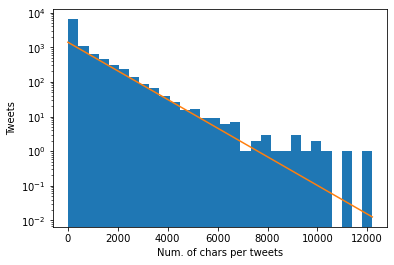

In [3]:
import matplotlib.pyplot as plt
import numpy as np

plt.hist(tweet_lengths, bins=30)
plt.xlabel('Num. of chars per tweets')
plt.ylabel('Tweets')
plt.yscale("log")

c1 = np.arange(0.0, 12200, 1)
t1 = 1400*np.exp(-c1/1050)

plt.plot(c1,t1)
plt.show()

We find a middle regime that follows an exponential law, and somewhat different behavior for small and large number of characters.

### Evolution of tweets on papers per year

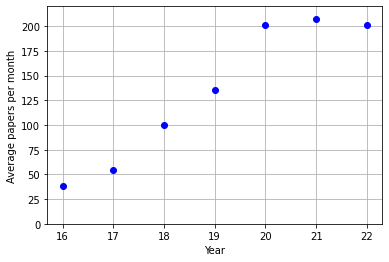

In [5]:
yr_p = [i for i in range(16,23)]  # year list
num_of_months_per_year = [len(df[df['year']==str(yr)]['month'].unique()) for yr in range(16,23)]  # count unique number of months in dataframe per year

num_per_year_per_month = [num_per_year[i]/num_of_months_per_year[i] for i in range(len(num_per_year))]  # normalize number of tweets per year per month
plt.plot(yr_p,num_per_year_per_month,'bo')
plt.xlabel('Year')
plt.ylabel('Average papers per month')
plt.grid()
plt.ylim([0, 220])

plt.show()

Obviously the above metric plot suffers from biases involving query choice, but it indicates the rise in popularity of academics in Twitter writing about their papers. 

Note, near the end of 2017, Twitter expanded their character limit from 140 to 280 characters per tweet, which could be a contributing factor to the increase.

### Investigate reallly long tweets

In [6]:
df['tweet_length'] = df['Tweets'].apply(lambda x: len(x))

df.loc[df['tweet_length']>8000]

,Unnamed: 0,TweetID,AuthorID,AuthorName,Tweets,arxiv_link,Abstract,Title,Thread_length,Tweets_coarse,year,month,tweet_length
2631,35,1196267948056424448,3245949691,Rebecca Leane,New paper! Cooking Pasta with Dark Matter: Kin...,https://arxiv.org/abs/1911.06334,Neutron stars serve as excellent next-generati...,Warming Nuclear Pasta with Dark Matter: Kineti...,36,['New paper!\n\nCooking Pasta with Dark Matter...,19,11,8981
4031,89,1212988781537554432,2416760538,Peter Gao,"New paper! ""Deflating Super-Puffs: Impact of P...",https://arxiv.org/abs/2001.00055,The observed mass-radius relationship of low-m...,Deflating Super-Puffs: Impact of Photochemical...,45,"['New paper! ""Deflating Super-Puffs: Impact of...",20,01,9857
4300,241,1311851889009418241,3245949691,Rebecca Leane,New paper! Exoplanets as New Sub-GeV Dark Matt...,https://arxiv.org/abs/2010.00015,We present exoplanets as new targets to discov...,Exoplanets as Sub-GeV Dark Matter Detectors,46,['New paper!\n\nExoplanets as New Sub-GeV Dark...,20,10,9231
4390,5,1334191213306654720,143430352,Rachael Meager,"Hello! Tamara Broderick, Ryan Giordano and I h...",https://arxiv.org/abs/2011.14999,We propose a method to assess the sensitivity ...,An Automatic Finite-Sample Robustness Metric: ...,71,"['Hello! Tamara Broderick, Ryan Giordano and I...",20,11,12188
4544,159,1332290582778142720,1212040530592333826,Sunny Vagnozzi,"A few days ago, with Avi Loeb from Harvard (th...",https://arxiv.org/abs/2011.11645,The question of whether Cosmic Microwave Backg...,Eppur \`e piatto? The cosmic chronometer take ...,43,"['A few days ago, with Avi Loeb from Harvard (...",20,11,10386
4640,68,1339231323995713537,4365927557,Dr. Jake Turner 🌅,"***New 1st author paper ***** ""The search for ...",http://arxiv.org/abs/2012.07926,Observing planetary auroral radio emission is ...,The search for radio emission from the exoplan...,31,"['***New 1st author paper *****\n\n""The search...",20,12,9509
4641,69,1339219770730799106,3308167500,"David C. Norris, MD 🌻",NEW #DTAT paper: What Were They Thinking? Phar...,https://arxiv.org/abs/2012.05301,"If explicit, formal consideration of clinical ...",What Were They Thinking? Pharmacologic priors ...,39,['NEW #DTAT paper: What Were They Thinking? Ph...,20,12,8580
4917,147,1234301978156634112,3245949691,Rebecca Leane,Galactic Center Excess update! <LINK> <LINK> W...,https://arxiv.org/abs/2002.12370,We re-examine evidence that the Galactic Cente...,Spurious Point Source Signals in the Galactic ...,46,['Galactic Center Excess update! \n<LINK>\n<LI...,20,02,9756
5090,4,1259420853026119682,2603024598,Ricardo Pérez-Marco,"New paper ""The Cantor Riemannium"". First examp...",https://arxiv.org/abs/2004.10541,The Riemann surface of a holomorphic germ is t...,The Cantor Riemannium,38,"['New paper ""The Cantor Riemannium"". First exa...",20,04,9131
5139,53,1255095770627428352,3308167500,"David C. Norris, MD 🌻","NEW WORKING PAPER @arxiv … A retrospective, mo...",https://arxiv.org/abs/2004.12755,The commonplace description of phase 1 clinica...,Retrospective analysis of a fatal dose-finding...,52,['NEW WORKING PAPER @arxiv …\n\nA retrospectiv...,20,04,11021


Apparently these threads are legit -- some authors are writing ~30 tweets or 10000 characters, roughly 2 two-column journal pages to my estimates -- A LOT!

### How many "reasonably-sized" tweets?

In [31]:
min_chars = 250
max_chars = 2500
df_mid = df.loc[df['tweet_length'] > min_chars].loc[df['tweet_length'] < max_chars]
df_mid.drop(['Unnamed: 0'], axis=1, inplace=True)
df_mid.reset_index()

len(df_mid)

4942

We find ~5000 tweets with characters count between 250 and 2500, roughly 50 to 500 tokens.

These cuts eliminate many tweets that write little on the paper or a lot on the paper, potentially surpassing an abstract's length.

#### Save "reasonably-sized" tweets

In [17]:
df_mid.to_csv('data/data_mid.csv')

### Train-Val-Test split

In [20]:
from sklearn.model_selection import train_test_split

df_mid_train, df_mid_rest = train_test_split(df_mid, test_size=0.2)
df_mid_val, df_mid_test = train_test_split(df_mid_rest, test_size=0.5)

df_mid_train.reset_index(inplace=True, drop=True)
df_mid_val.reset_index(inplace=True, drop=True)
df_mid_test.reset_index(inplace=True, drop=True)


In [21]:
# save sub-datasets
df_mid_train.to_csv('data/data_mid_train.csv')
df_mid_val.to_csv('data/data_mid_val.csv')
df_mid_test.to_csv('data/data_mid_test.csv')

#### Save small dataset for debugging

In [22]:
df_mid_most, df_mid_debug = train_test_split(df_mid, test_size=0.07)

df_mid_debug_train, df_mid_debug_rest = train_test_split(df_mid_debug, test_size=0.2)
df_mid_debug_val, df_mid_debug_test = train_test_split(df_mid_debug_rest, test_size=0.5)

df_mid_debug_train.reset_index(inplace=True, drop=True)
df_mid_debug_val.reset_index(inplace=True, drop=True)
df_mid_debug_test.reset_index(inplace=True, drop=True)

df_mid_debug_train.to_csv('data/data_mid_debug_train.csv')
df_mid_debug_val.to_csv('data/data_mid_debug_val.csv')
df_mid_debug_test.to_csv('data/data_mid_debug_test.csv')

# Sentiment

Let us conduct an exploratory sentiment analysis with a built-in took of NLTK.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
df = pd.read_csv('data/full_data.csv')

In [2]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/nitsanbar/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [3]:
# we define a minimal procedure to remove "bad sentences". Currently, it removes sentences which are very short (< 15 chars) or contain only a particular token (currently '<LINK>')
def remove_bad_sentences(list, min_len=15, bad_word_list=["<LINK>"]):
    good_sentences = []
    for sentence in list:
        # if sentence equals a string in list
        if sentence in bad_word_list:
            continue
        if len(sentence) < min_len:
            continue
        good_sentences.append(sentence)
    return good_sentences

In [4]:
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.tokenize import sent_tokenize, word_tokenize

sia = SentimentIntensityAnalyzer()
sia_scores = []

min_num_sentences = 5
property = 'pos'
sia_prop_moments = []
sia_prop = []
# run on dataframe of tweets
for i in range(len(df)):
    tweet = df['Tweets'][i]

    # compute overall sia score for the tweet
    sia_scores.append(sia.polarity_scores(tweet))
    
    # tokenize the tweet into sentences, then compute sia score for each sentence and compute the "moment" of a property defined above
    sent_list = sent_tokenize(tweet)
    sent_list = remove_bad_sentences(sent_list)
    
    # only conduct a sentence-by-sentence analysis if the tweet has at least min_num_sentences
    if len(sent_list) >= min_num_sentences:
        sum_prop_moment = 0
        sum_prop = 0
        for i, sent in enumerate(sent_list):
            sia_sent = sia.polarity_scores(sent)
            sum_prop_moment += sia_sent[property] * i / (len(sent_list) - 1)
            sum_prop += sia_sent[property]
        if sum_prop_moment == 0 and sum_prop == 0:
            prop_moment = 0
        else:
            prop_moment = sum_prop_moment / sum_prop
        sia_prop_moments.append(prop_moment)
        sia_prop.append(sum_prop / len(sent_list))

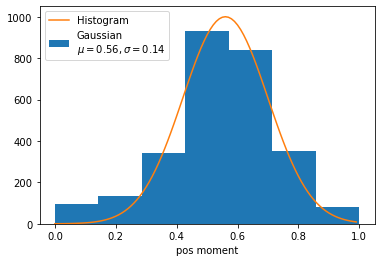

In [5]:
# plot sia_prop_moments histogram
plt.hist(sia_prop_moments, bins=7)

# plot gaussian curve
c1 = np.arange(0.0, 1.0, 0.01)
t1 = 1000* np.exp(-(c1-0.56)**2/(2*0.14**2))
plt.plot(c1,t1)
plt.xlabel(property + ' moment')
plt.legend(['Histogram', 'Gaussian\n$\mu=0.56, \sigma=0.14$'], loc='upper left')
plt.show()


The moment suggests that a positive sentiment is not particularly skewed necessarily towards the beginning or the end of the Tweet. This conclusion is somewhat preliminary however, since we used a sentiment analysis tool which is not specialized to Twitter.

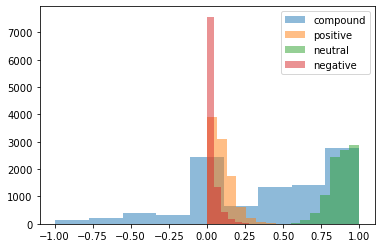

In [6]:
compound_score = [sia_score['compound'] for sia_score in sia_scores]
pos_score = [sia_score['pos'] for sia_score in sia_scores]
neu_score = [sia_score['neu'] for sia_score in sia_scores]
neg_score = [sia_score['neg'] for sia_score in sia_scores]
# plot histogram of compound score
plt.hist(compound_score, alpha=0.5, bins=9)
plt.hist(pos_score, alpha=0.5,bins=9)
plt.hist(neu_score, alpha=0.5,bins=9)
plt.hist(neg_score, alpha=0.5,bins=9)
plt.legend(['compound','positive','neutral','negative'])
plt.show()

By the metric of the sentiment scores that we adopted, we find that our Tweets are more positive than negative (not a shocker), but generally neutral (perhaps not a shocker).

# Exploratory ROUGE

Here we don't really do ROUGE in the sense of evaluating given summary vs. generated summary (this we do after training, in evaluate_predictions.ipynb). We adopt the ROUGE metric as a comparison between an abstract and the real Tweet.

In [24]:
from datasets import load_metric

rouge_score = load_metric("rouge")

In [26]:
score_list = []

for label_example, text_example in zip(df_mid['Tweets'],df_mid['Abstract']):
    scores = rouge_score.compute(predictions=[label_example], references=[text_example])
    
    score_list.append(scores)

In [27]:
rouge1_mid_fmeasure_base = [score_list[i]['rouge1'].mid.fmeasure for i in range(len(score_list))]
rouge2_mid_fmeasure_base = [score_list[i]['rouge2'].mid.fmeasure for i in range(len(score_list))]
rougeL_mid_fmeasure_base = [score_list[i]['rougeL'].mid.fmeasure for i in range(len(score_list))]

rouge1_mid_precision_base = [score_list[i]['rouge1'].mid.precision for i in range(len(score_list))]
rouge2_mid_precision_base = [score_list[i]['rouge2'].mid.precision for i in range(len(score_list))]
rougeL_mid_precision_base = [score_list[i]['rougeL'].mid.precision for i in range(len(score_list))]

### Baseline ROUGE score histogram

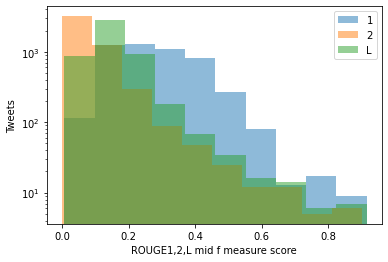

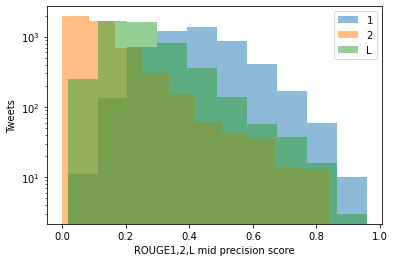

In [28]:
plt.hist(rouge1_mid_fmeasure_base, alpha=0.5)
plt.hist(rouge2_mid_fmeasure_base, alpha=0.5)
plt.hist(rougeL_mid_fmeasure_base, alpha=0.5)
plt.xlabel('ROUGE1,2,L mid f measure score')
plt.ylabel('Tweets')
plt.yscale("log")
plt.legend(['1','2','L'])
plt.show()

plt.hist(rouge1_mid_precision_base, alpha=0.5)
plt.hist(rouge2_mid_precision_base, alpha=0.5)
plt.hist(rougeL_mid_precision_base, alpha=0.5)
plt.xlabel('ROUGE1,2,L mid precision score')
plt.ylabel('Tweets')
plt.yscale("log")
plt.legend(['1','2','L'])
plt.show()

# Subjects

In this section we investigate the subject distribution . After collecting the data, I wanted to check the distribution of arXiv sections (e.g. hep, astro, cs, etc.). Since I didn't save the entire arXiv pages and I didn't want to run the Twitter scan from scrach, I wrote below a code that obtains this information, resaves the full_data.csv as full_data_subjects.csv, and plots a few statistics.

In [4]:
# parsing functions, slightly modified from data_pull/arxiv_utils.py
from html.parser import HTMLParser
import requests

class arXivHTMLParser(HTMLParser):
    '''
    Based on https://docs.python.org/3/library/html.parser.html
    '''
    def __init__(self):
        HTMLParser.__init__(self)
        
        self.title = ''
        self.authors = []
        self.abstract = ''
        
        self.title_flag = False
        self.authors_flag = False
        self.abstract_flag = False
        self.metadata = []
        self.metatable_flag = False
        
    def handle_starttag(self, tag, attrs):
        # print("Encountered a start tag:", tag)
        if tag == 'title' and self.title == '' :
            self.title_flag = True
        for attr in attrs:
            if attr == ('class', 'metatable'):
                self.metatable_flag = True

    def handle_endtag(self, tag):
        # print("Encountered an end tag :", tag)
        if tag == 'title':
            self.title_flag = False
            
        if self.authors_flag and tag == 'div':
            self.authors_flag = False
        
        if self.abstract_flag and tag == 'blockquote':
            self.abstract_flag = False
        
    def handle_data(self, data):
        # print("Encountered some data  :", data)
        if self.title_flag:
            self.title = data
            
        if data == 'Authors:':
            self.authors_flag = True
        
        if self.authors_flag and data != 'Authors:' and data != ', ':
            self.authors.append(data)

        if data == 'Abstract:':
            self.abstract_flag = True
            
        if data != 'Abstract:' and self.abstract_flag:
            self.abstract = self.abstract + data

        if self.metatable_flag:
            if data == 'Which authors of this paper are endorsers?':
                self.metatable_flag = False
            if data != '\n':
                self.metadata.append(data)

            
def get_arXiv_details(url):
    '''
        This method uses the above HTML parser (arXivHTMLParser)
        accepts a url of the variety 'https://arxiv.org/abs/xxxx.xxxxx'
        returns the [title, authors, abstracts]
        
        does not support comments, journal, and other information -- but can be extended to support it by modifying this method and the parser
    '''
    url = url.replace('arxiv','export.arxiv') # arxiv asks bots to use this website, see https://arxiv.org/denied.html ; otherwise it blocks the bot often
    
    req = requests.get(url, 'html.parser')
    parser = arXivHTMLParser()
    parser.feed(req.text)
    
    parser.title = parser.title[13:] # in title: remove [xxxx.xxxxx] prefix
    parser.abstract = parser.abstract.replace('\n',' ')[1:] # replace \n by space and remove two spaces in the beginning ('  '). Used to be 2: with arxiv.org rather than export.arxiv.org
    
    # remove extra entries from author list. Was unnecessary in arxiv.org, became necessary with export.arxiv.org
    try:
        parser.authors.remove('\n')
    except:
        pass
    try:
        while True:
            parser.authors.remove(', \n')
    except ValueError:
        pass
    
    return parser.title, parser.authors, parser.abstract, parser.metadata

In [5]:
# dedicated functions for parsing subjects
import re

def get_subjects_from_line(line):
    listparse = re.findall(r'\([^()]*\)', line)
    return [listparse[i][1:-1] for i in range(len(listparse))]
    
def get_subjects(metadata):
    for i, line in enumerate(metadata):
        if line == 'Subjects:':
            break
    subject_main = metadata[i+1]
    subject_main = get_subjects_from_line(subject_main)

    subject_cross = ''
    if metadata[i+2][0] == ';':
        subject_cross = metadata[i+2]
    subject_cross = get_subjects_from_line(subject_cross)

    for subject in subject_cross:
        subject_main.append(subject)

    return subject_main

In [50]:
# load data
import pandas as pd
df = pd.read_csv('data/full_data.csv')

In [51]:
# actual re-run on arxiv, very long run-time, better skip and load from file
metadata_list = []
df_arxiv_subjects = []
i = 0
while True:
    try:
        title, authors, abstract, metadata = get_arXiv_details(df['arxiv_link'].iloc[i])
        metadata = [metadata[i].replace('\n','') for i in range(len(metadata))]
        metadata_list.append(metadata)
        df_arxiv_subjects.append(get_subjects(metadata))
        i += 1
    except:
        continue
    if i == len(df):
        break

In [55]:
# insert new list into dataframe
df.insert(len(df.columns), 'arxiv_subjects', df_arxiv_subjects)
df.head(4)

,Unnamed: 0,TweetID,AuthorID,AuthorName,Tweets,arxiv_link,Abstract,Title,Thread_length,Tweets_coarse,arxiv_subjects
0,0,695565872891621376,75249390,Axel Maas,I have published a new blog entry on our recen...,http://arxiv.org/abs/1601.02006,Observable states are gauge-invariant. In a no...,Gauge invariance and the physical spectrum in ...,1,['I have published a new blog entry on our rec...,[hep-ph]
1,1,694223402932899841,212431150,Faryad Sahneh,"Our new paper: ""Sequential Monte Carlo Filteri...",http://arxiv.org/abs/1601.07606,We use a multivariate formulation of sequentia...,Sequential Monte Carlo Filtering Estimation of...,1,"['Our new paper: ""Sequential Monte Carlo Filte...","[stat.AP, q-bio.PE]"
2,2,694093392414937088,2999702157,Anton Ilderton,New paper on measuring vacuum birefringence us...,http://arxiv.org/abs/1601.08045,The measurement of vacuum polarisation effects...,Prospects for studying vacuum polarisation usi...,1,['New paper on measuring vacuum birefringence ...,"[hep-ph, physics.optics]"
3,3,694076172372697088,1430303833,Dave Woods,New paper on arXiv on screening for GLMs with ...,http://arxiv.org/abs/1601.08088,The first investigation is made of designs for...,Model selection via Bayesian information capac...,1,['New paper on arXiv on screening for GLMs wit...,[stat.ME]


In [56]:
# uncomment to save again. Generating this dataset takes a long time, so commented to avoid overwrite in a mass run
# df.to_csv('data/full_data_subjects.csv')

In [3]:
# reload modified data
import ast
import pandas as pd
df = pd.read_csv('data/full_data_subjects.csv')
df['arxiv_subjects'] = df['arxiv_subjects'].apply(lambda x: ast.literal_eval(x))
df.head(5)

,Unnamed: 0,Unnamed: 0.1,TweetID,AuthorID,AuthorName,Tweets,arxiv_link,Abstract,Title,Thread_length,Tweets_coarse,arxiv_subjects
0,0,0,695565872891621376,75249390,Axel Maas,I have published a new blog entry on our recen...,http://arxiv.org/abs/1601.02006,Observable states are gauge-invariant. In a no...,Gauge invariance and the physical spectrum in ...,1,['I have published a new blog entry on our rec...,[hep-ph]
1,1,1,694223402932899841,212431150,Faryad Sahneh,"Our new paper: ""Sequential Monte Carlo Filteri...",http://arxiv.org/abs/1601.07606,We use a multivariate formulation of sequentia...,Sequential Monte Carlo Filtering Estimation of...,1,"['Our new paper: ""Sequential Monte Carlo Filte...","[stat.AP, q-bio.PE]"
2,2,2,694093392414937088,2999702157,Anton Ilderton,New paper on measuring vacuum birefringence us...,http://arxiv.org/abs/1601.08045,The measurement of vacuum polarisation effects...,Prospects for studying vacuum polarisation usi...,1,['New paper on measuring vacuum birefringence ...,"[hep-ph, physics.optics]"
3,3,3,694076172372697088,1430303833,Dave Woods,New paper on arXiv on screening for GLMs with ...,http://arxiv.org/abs/1601.08088,The first investigation is made of designs for...,Model selection via Bayesian information capac...,1,['New paper on arXiv on screening for GLMs wit...,[stat.ME]
4,4,4,693490180162977792,180240998,Franck Marchis,"New @PlanetImager paper ""The PDS 66 Circumstel...",https://arxiv.org/abs/1601.07248,We present H and K band imaging polarimetry fo...,The PDS 66 Circumstellar Disk as seen in Polar...,1,"['New @PlanetImager paper ""The PDS 66 Circumst...",[astro-ph.EP]


Statistics of subjects

<AxesSubplot:>

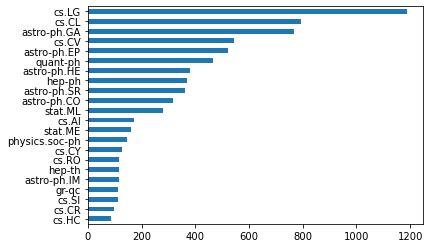

In [4]:
subject_counts = df['arxiv_subjects'].apply(lambda x: x[0]).value_counts()
subject_counts[subject_counts>80].sort_values().plot(kind = 'barh')

The plot above is a bar plot of how many papers have a subject as their primary subject on arXiv -- in the full dataset -- with at least 80 occurences in the dataset.
Perhaps not suprisingly, we find booming sections in computer science leading, along with astrophysics.

Out of curiousity, let's check secondary sections:

<AxesSubplot:>

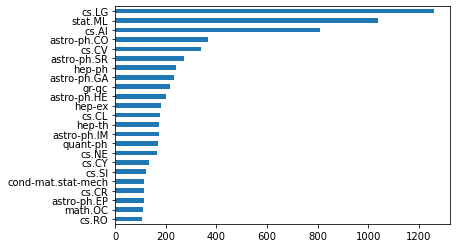

In [20]:
# get df where length of arxiv_subjects is 2 or more
df_subjects_multiple = df[df['arxiv_subjects'].apply(lambda x: len(x)>1)]
list_secondary = df_subjects_multiple['arxiv_subjects'].apply(lambda x: x[1:]).to_list()
list_secondary_flat = [item for sublist in list_secondary for item in sublist] # flatten list
# return to dataframe and plot
secondary_df = pd.Series(list_secondary_flat).value_counts()
secondary_df[secondary_df>100].sort_values().plot(kind = 'barh')

This can be compared with https://arxiv.org/help/stats/2021_by_area

Some cute sociological trends can be found. For example, even though the math section of arXiv is a factor of ~2 less prolific than cs, the math section is highly under-represented in our dataset, perhaps indicating that the math community is considerably less engaged in Twitter compared to math and physics communities.